# 1 Understanding Funding Fees

On most platforms, Funding Fees are paid hourly based on the difference between the future and spot price. For more details about funding rates, please refer to the [Hyperliquid Docs](https://hyperliquid.gitbook.io/hyperliquid-docs/trading/funding) and [Coinbase Docs](https://help.coinbase.com/en/international-exchange/funding/how-is-the-funding-rate-determined).

For the sake of simplicity, we shall focus on using data extracted from Hyperliquid (aggregation) and Binance (individual exchange) to attempt to understand the behaviour of funding rates, and how much we should expect to be paying.

There should be an analytical solution for this...

Some of the questions I want to answer
1. What is the average funding rate historically?
2. What sort of distribution is the funding rates? (assuming Funding Rate is mean reverting)
3. What is the expected amount that I can pay for a certain duration for Bitcoin?
   1. monte carlo simulation? -> mean of 10.95%
   2. hourly data -> how much I can expect to pay for a portfolio (in notional value?)
   3. For 1 / 2 / 3 month, how much funding should I expect to pay? What is the range of values that I will expect to pay?
4. How is the different for the different tokens?

## Assumptions
1. Funding Rates are IID
2. Funding Rates across platforms are non-correlated.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json

from datetime import datetime, timedelta
import pytz

import scipy.stats as scipy_stats
   

# Coinbase

https://github.com/coinbase/coinbase-advanced-py/

Endpoint: [Get historical funding rates](https://docs.cdp.coinbase.com/intx/reference/getInstrumentFunding/)

PROBLEM: NEED TO FIGURE OUT HOW TO GET >100 data points

In [2]:
def get_coinbase_funding(instrument):
    url = f"""https://api.international.coinbase.com/api/v1/instruments/{instrument}/funding"""
    headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }
    params = {
        'result_limit': 100,
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json()

data = get_coinbase_funding('BTC-PERP')
data


{'pagination': {'result_limit': 100, 'result_offset': 0},
 'results': [{'instrument_id': '149264167780483072',
   'funding_rate': '0.000003',
   'mark_price': '102156.1',
   'event_time': '2025-02-01T08:00:00Z'},
  {'instrument_id': '149264167780483072',
   'funding_rate': '0.000003',
   'mark_price': '102396',
   'event_time': '2025-02-01T07:00:00Z'},
  {'instrument_id': '149264167780483072',
   'funding_rate': '0.000003',
   'mark_price': '102485.6',
   'event_time': '2025-02-01T06:00:00Z'},
  {'instrument_id': '149264167780483072',
   'funding_rate': '0.000002',
   'mark_price': '102300.9',
   'event_time': '2025-02-01T05:00:00Z'},
  {'instrument_id': '149264167780483072',
   'funding_rate': '0.000002',
   'mark_price': '102229.5',
   'event_time': '2025-02-01T04:00:00Z'},
  {'instrument_id': '149264167780483072',
   'funding_rate': '0.000002',
   'mark_price': '102437.2',
   'event_time': '2025-02-01T03:00:00Z'},
  {'instrument_id': '149264167780483072',
   'funding_rate': '0.00000

In [3]:
df = pd.DataFrame(data['results'])
df['funding_rate'] = df['funding_rate'].astype(float)
df['funding_annualized'] = df['funding_rate'].apply(lambda x : x * 24 * 365 * 100)
df['event_time'] = pd.to_datetime(df['event_time'])
df

,instrument_id,funding_rate,mark_price,event_time,funding_annualized
0,149264167780483072,0.000003,102156.1,2025-02-01 08:00:00+00:00,2.628
1,149264167780483072,0.000003,102396,2025-02-01 07:00:00+00:00,2.628
2,149264167780483072,0.000003,102485.6,2025-02-01 06:00:00+00:00,2.628
3,149264167780483072,0.000002,102300.9,2025-02-01 05:00:00+00:00,1.752
4,149264167780483072,0.000002,102229.5,2025-02-01 04:00:00+00:00,1.752
...,...,...,...,...,...
95,149264167780483072,0.000001,102859.9,2025-01-28 09:00:00+00:00,0.876
96,149264167780483072,-0.000002,102800,2025-01-28 08:00:00+00:00,-1.752
97,149264167780483072,-0.000003,102731.8,2025-01-28 07:00:00+00:00,-2.628
98,149264167780483072,-0.000003,103006.1,2025-01-28 06:00:00+00:00,-2.628


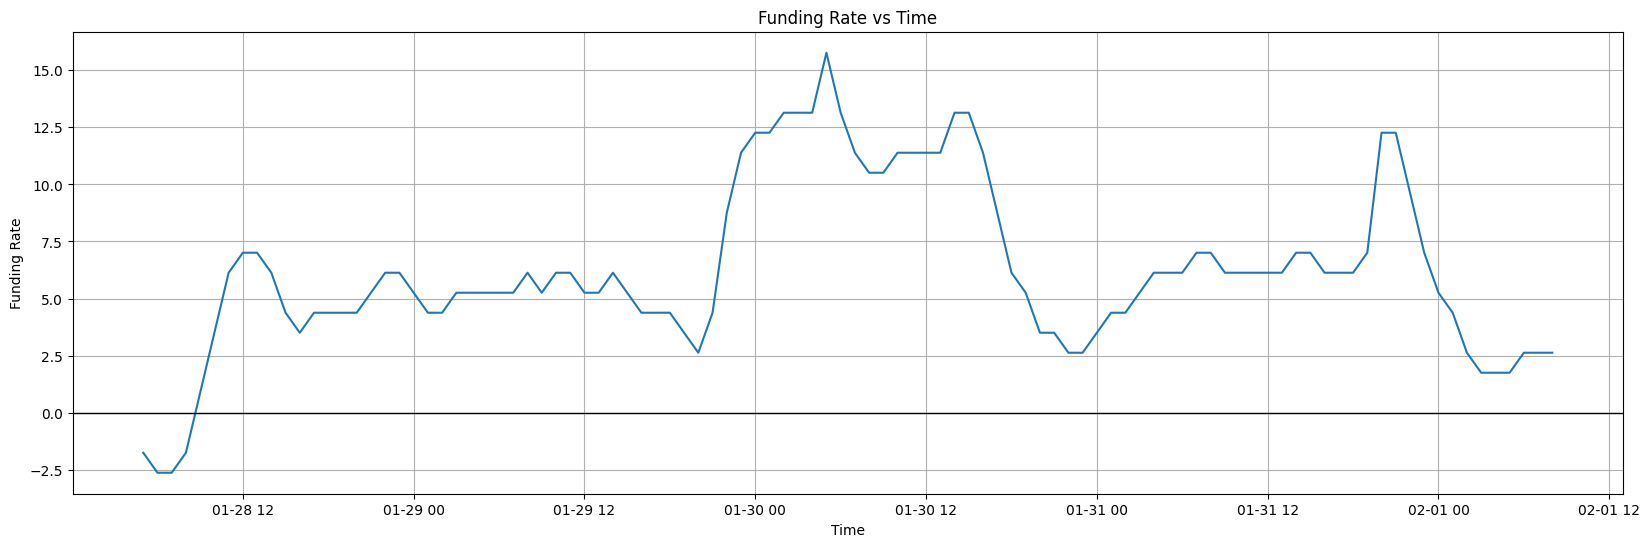

In [4]:
def plot_data(df, x_col, y_col, plot_type='scatter', title=None, xlabel=None, ylabel=None):   
   plt.figure(figsize=(20,6))
   
   if plot_type == 'scatter':
       plt.scatter(df[x_col], df[y_col])
   elif plot_type == 'line': 
       plt.plot(df[x_col], df[y_col])
       
   plt.title(title or f'{y_col} vs {x_col}')
   plt.axhline(0, color='black', lw=1)
   plt.xlabel(xlabel or x_col)
   plt.ylabel(ylabel or y_col)
   plt.grid(True)
   plt.show()

plot_data (df, 'event_time', 'funding_annualized', plot_type='line', title='Funding Rate vs Time', xlabel='Time', ylabel='Funding Rate')

# Hyperliquid

Endpoint: [Retrieve historical funding rates](https://hyperliquid.gitbook.io/hyperliquid-docs/for-developers/api/info-endpoint/perpetuals#retrieve-historical-funding-rates)

In [5]:
url = f"""https://api.hyperliquid.xyz/info"""
headers = {
    "Content-Type" : "application/json",
}
payload = {
    "type": "fundingHistory",
    "coin": "ETH",
    "startTime": 1838363554000,
}
response = requests.post(url, headers=headers, data=json.dumps(payload))
response.json()

[]

In [6]:
def get_hyperliquid_funding(instrument, startTime, endTime = int(datetime.now(tz=pytz.UTC).timestamp() * 1000)):
    url = f"""https://api.hyperliquid.xyz/info"""
    headers = {
        "Content-Type" : "application/json",
    }
    all_data = []

    query_time = startTime
    print(f"""Hyperliquid : Querying funding data for {instrument} from {datetime.fromtimestamp(startTime/1000).strftime("%Y-%m-%d %H:%M:%S")} to {datetime.fromtimestamp(endTime/1000).strftime("%Y-%m-%d %H:%M:%S")}""")
    while query_time < endTime:
        payload = {
            "type": "fundingHistory",
            "coin": instrument,
            "startTime": query_time,
            "endTime": endTime
        }
        response = requests.post(url, headers=headers, json=payload)
        # return response.text
        if response.status_code != 200:
            raise Exception(f"Error {response.status_code} : {response.text}")
        data = response.json()
        if len(data) == 0:
            break
        all_data.extend(data)

        # update query_time
        query_time = data[-1]['time'] + 1

    return all_data
startTime = int(datetime(2023, 7, 1, 0, 0, 0, tzinfo=pytz.UTC).timestamp() * 1000)
data = get_hyperliquid_funding(instrument='BTC', startTime=startTime)
data

Hyperliquid : Querying funding data for BTC from 2023-07-01 08:00:00 to 2025-02-01 16:17:37


[{'coin': 'BTC',
  'fundingRate': '0.00005087',
  'premium': '0.00040698',
  'time': 1688169600189},
 {'coin': 'BTC',
  'fundingRate': '0.00005791',
  'premium': '0.00046326',
  'time': 1688173200008},
 {'coin': 'BTC',
  'fundingRate': '0.00004873',
  'premium': '0.00038988',
  'time': 1688176800067},
 {'coin': 'BTC',
  'fundingRate': '0.00004512',
  'premium': '0.00036094',
  'time': 1688180400024},
 {'coin': 'BTC',
  'fundingRate': '0.0000399',
  'premium': '0.00031921',
  'time': 1688184000166},
 {'coin': 'BTC',
  'fundingRate': '0.00005543',
  'premium': '0.00044343',
  'time': 1688187600117},
 {'coin': 'BTC',
  'fundingRate': '0.00004059',
  'premium': '0.0003247',
  'time': 1688191200051},
 {'coin': 'BTC',
  'fundingRate': '0.00003471',
  'premium': '0.00027766',
  'time': 1688194800137},
 {'coin': 'BTC',
  'fundingRate': '0.00003934',
  'premium': '0.00031475',
  'time': 1688198400278},
 {'coin': 'BTC',
  'fundingRate': '0.00003513',
  'premium': '0.00028105',
  'time': 16882020

In [7]:
hl_df = pd.DataFrame(data)
hl_df['datetime'] = pd.to_datetime(hl_df['time'], unit='ms')
hl_df['premium'] = hl_df['premium'].astype(float)
hl_df['fundingRate'] = hl_df['fundingRate'].astype(float)
hl_df['annualizedFundingRate'] = hl_df['fundingRate'].apply(lambda x : x * 24 * 365 * 100)

hl_df

,coin,fundingRate,premium,time,datetime,annualizedFundingRate
0,BTC,0.000051,0.000407,1688169600189,2023-07-01 00:00:00.189,44.56212
1,BTC,0.000058,0.000463,1688173200008,2023-07-01 01:00:00.008,50.72916
2,BTC,0.000049,0.000390,1688176800067,2023-07-01 02:00:00.067,42.68748
3,BTC,0.000045,0.000361,1688180400024,2023-07-01 03:00:00.024,39.52512
4,BTC,0.000040,0.000319,1688184000166,2023-07-01 04:00:00.166,34.95240
...,...,...,...,...,...,...
13945,BTC,0.000013,0.000169,1738382400013,2025-02-01 04:00:00.013,10.95000
13946,BTC,0.000013,0.000114,1738386000078,2025-02-01 05:00:00.078,10.95000
13947,BTC,0.000013,0.000272,1738389600093,2025-02-01 06:00:00.093,10.95000
13948,BTC,0.000013,0.000213,1738393200166,2025-02-01 07:00:00.166,10.95000


In [8]:
hl_df['fundingRate'].describe()

count    13950.000000
mean         0.000024
std          0.000034
min         -0.000166
25%          0.000013
50%          0.000013
75%          0.000029
max          0.000598
Name: fundingRate, dtype: float64

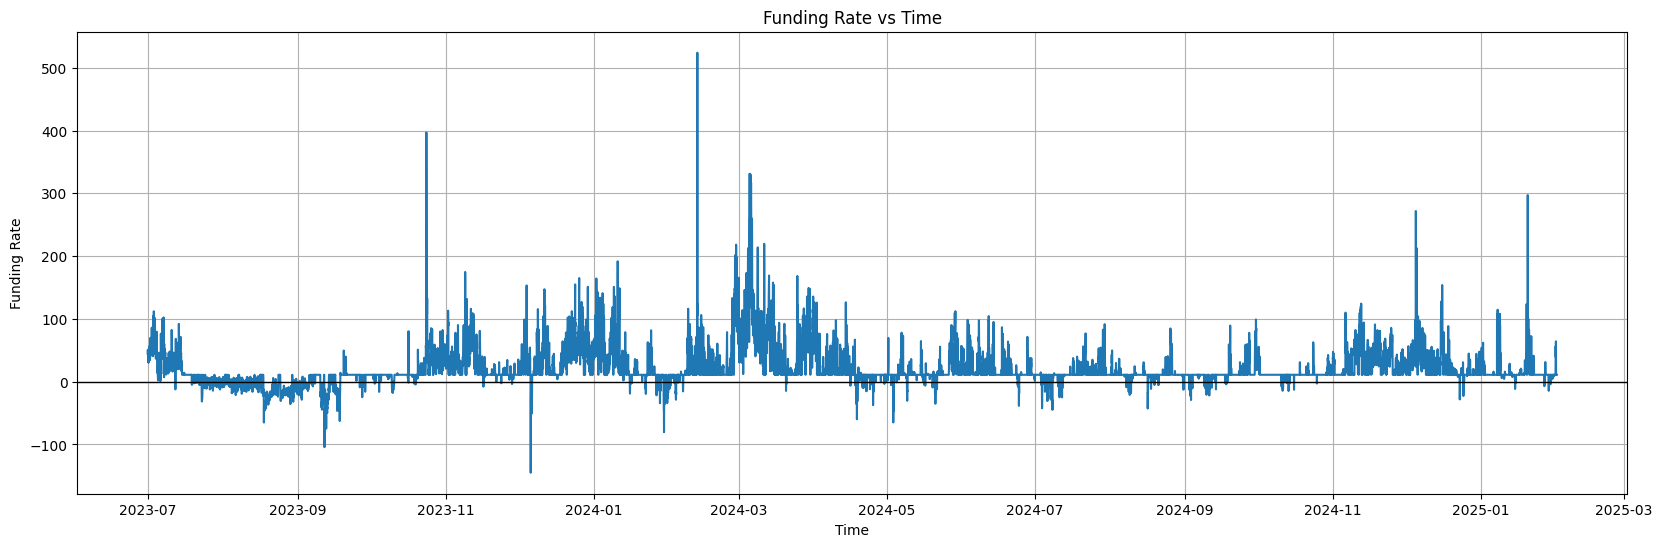

In [9]:
plot_data (hl_df, 'datetime', 'annualizedFundingRate', plot_type='line', title='Funding Rate vs Time', xlabel='Time', ylabel='Funding Rate')

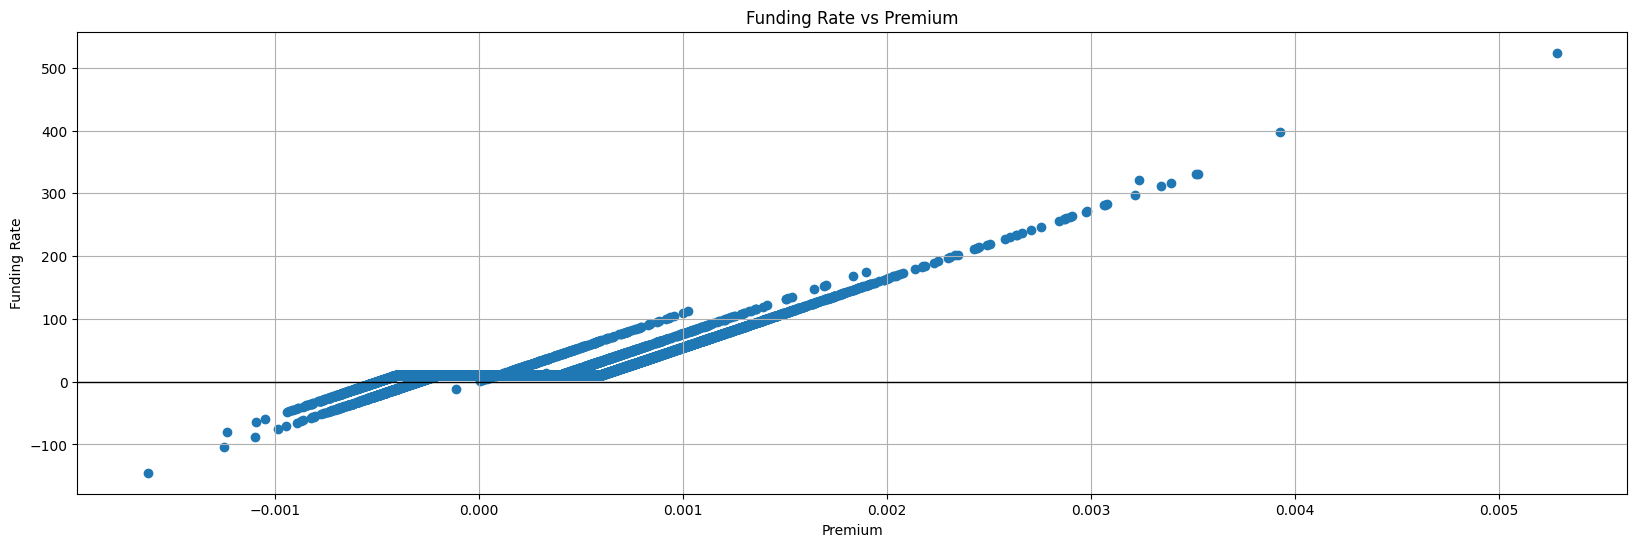

In [10]:
plot_data(hl_df, x_col='premium', y_col='annualizedFundingRate', plot_type='scatter', title='Funding Rate vs Premium', xlabel='Premium', ylabel='Funding Rate')

## 1 What is the average funding rate historically?

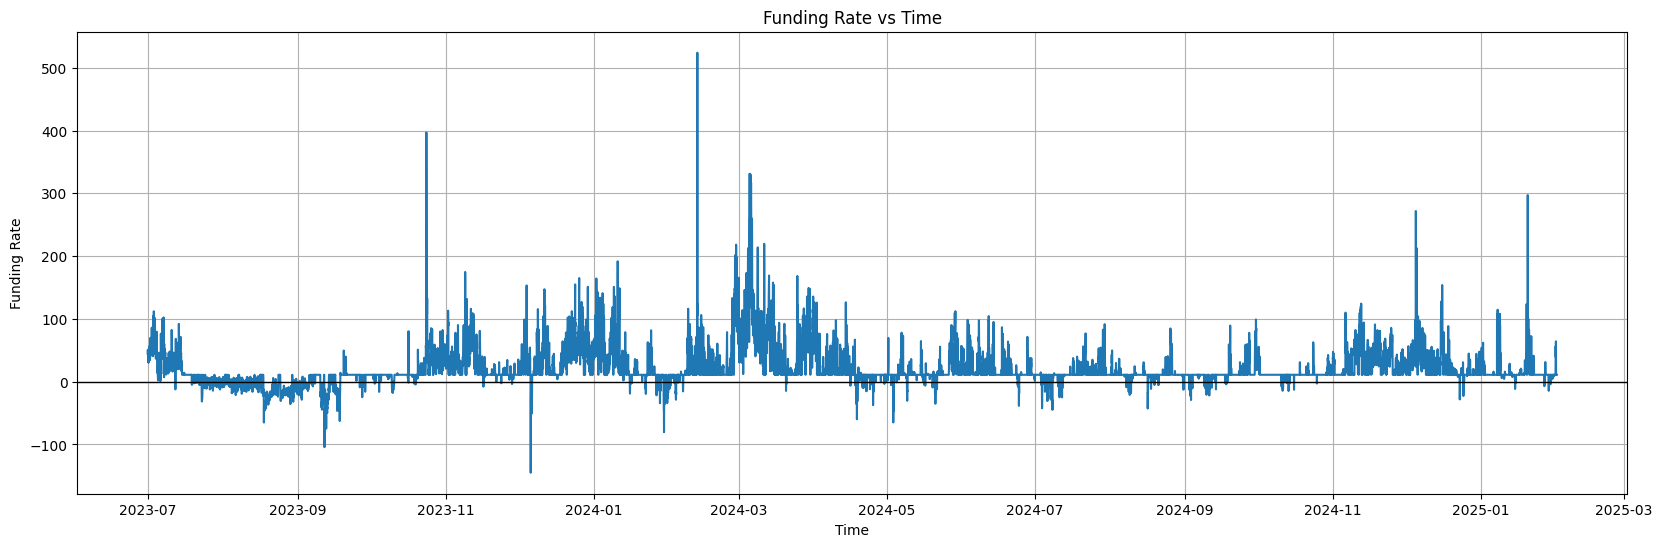

In [11]:
plot_data (hl_df, 'datetime', 'annualizedFundingRate', plot_type='line', title='Funding Rate vs Time', xlabel='Time', ylabel='Funding Rate')

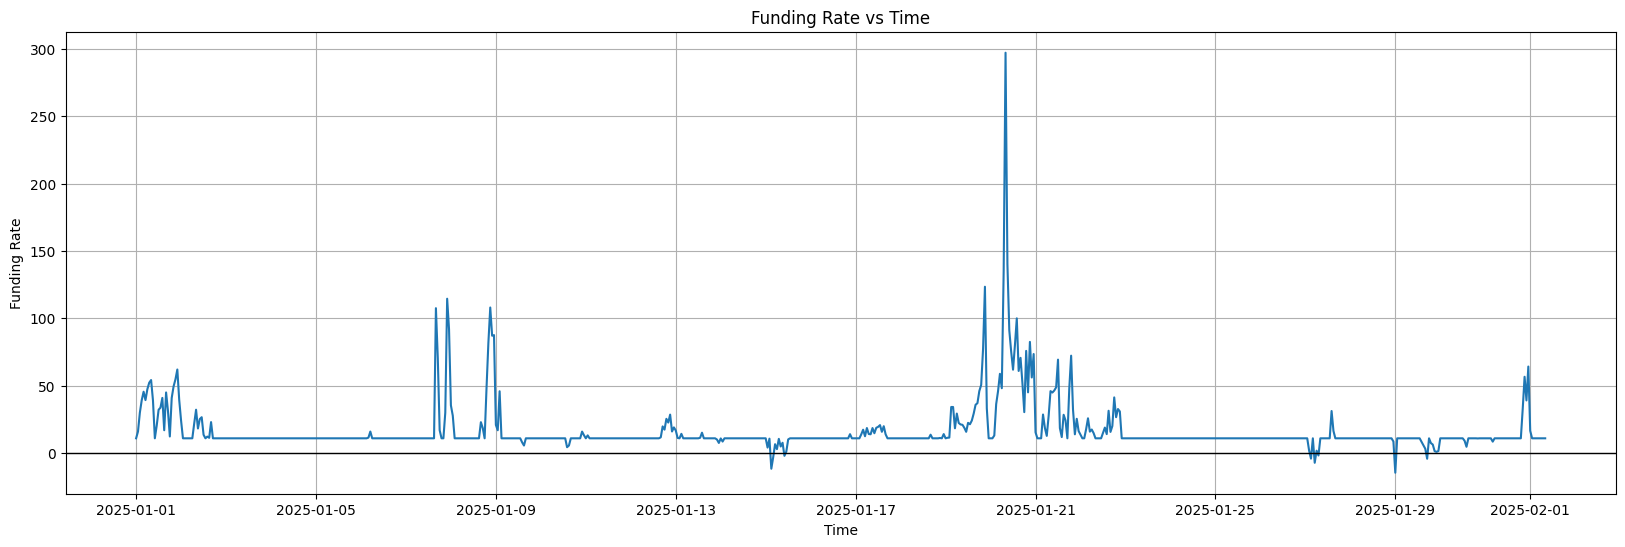

In [12]:
plot_data (hl_df[hl_df['datetime'] >= '2025-01-01'], 'datetime', 'annualizedFundingRate', plot_type='line', title='Funding Rate vs Time', xlabel='Time', ylabel='Funding Rate')

## 2 What sort of distribution is the funding rates? (assuming Funding Rate is mean reverting)

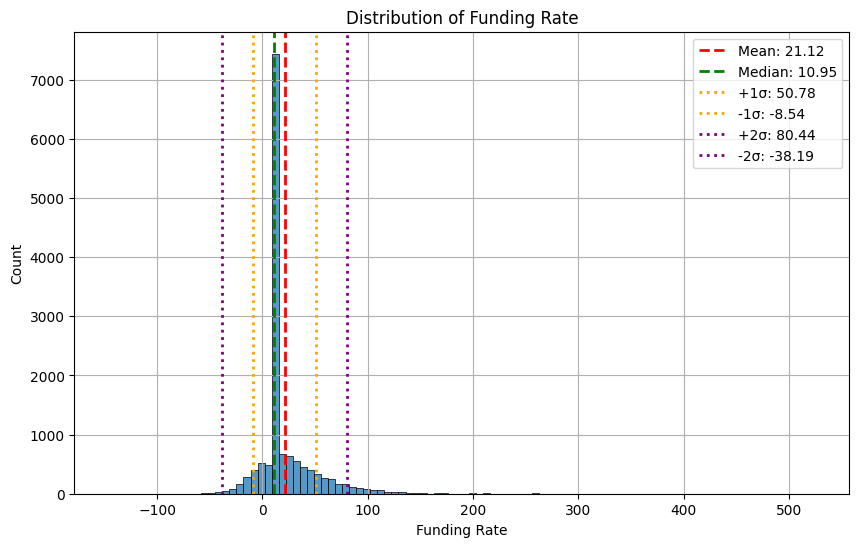

Skewness: 3.069
Kurtosis: 20.988


In [ ]:
def plot_distribution(df, column, bins=30, title=None, xlabel=None):
   """Plot histogram with statistical markers"""
   mean = df[column].mean()
   median = df[column].median()
   std = df[column].std()
   
   plt.figure(figsize=(10,6))
   sns.histplot(data=df[column], bins=bins)
   
   # Add vertical lines for statistics
   plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
   plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
   
   # 1 and 2 std deviations
   plt.axvline(mean + std, color='orange', linestyle=':', linewidth=2, label=f'+1σ: {(mean+std):.2f}')
   plt.axvline(mean - std, color='orange', linestyle=':', linewidth=2, label=f'-1σ: {(mean-std):.2f}')
   plt.axvline(mean + 2*std, color='purple', linestyle=':', linewidth=2, label=f'+2σ: {(mean+2*std):.2f}')
   plt.axvline(mean - 2*std, color='purple', linestyle=':', linewidth=2, label=f'-2σ: {(mean-2*std):.2f}')
   
   plt.title(title or f'Distribution of {column}')
   plt.xlabel(xlabel or column)
   plt.ylabel('Count')
   plt.legend()
   plt.grid(True)
   plt.show()

def analyze_distribution(df, column):
   """Calculate distribution statistics"""
   
   skew = stats.skew(df[column])
   kurt = stats.kurtosis(df[column]) # Fisher kurtosis (normal = 0)
   
   print(f"Skewness: {skew:.3f}")
   print(f"Kurtosis: {kurt:.3f}")

plot_distribution(hl_df, 'annualizedFundingRate', bins=100, title='Distribution of Funding Rate', xlabel='Funding Rate')
analyze_distribution(hl_df, 'annualizedFundingRate')

So we attempt to build a distribution using these values. There are multiple solutions to model the distribution, however, in this context we are not too particular about the model. 

## 3 What is the expected amount that I can pay for a certain duration for Bitcoin?

Steps
1. Fit the distribution of hourly funding rate. Assuming that you are summing the amount at every

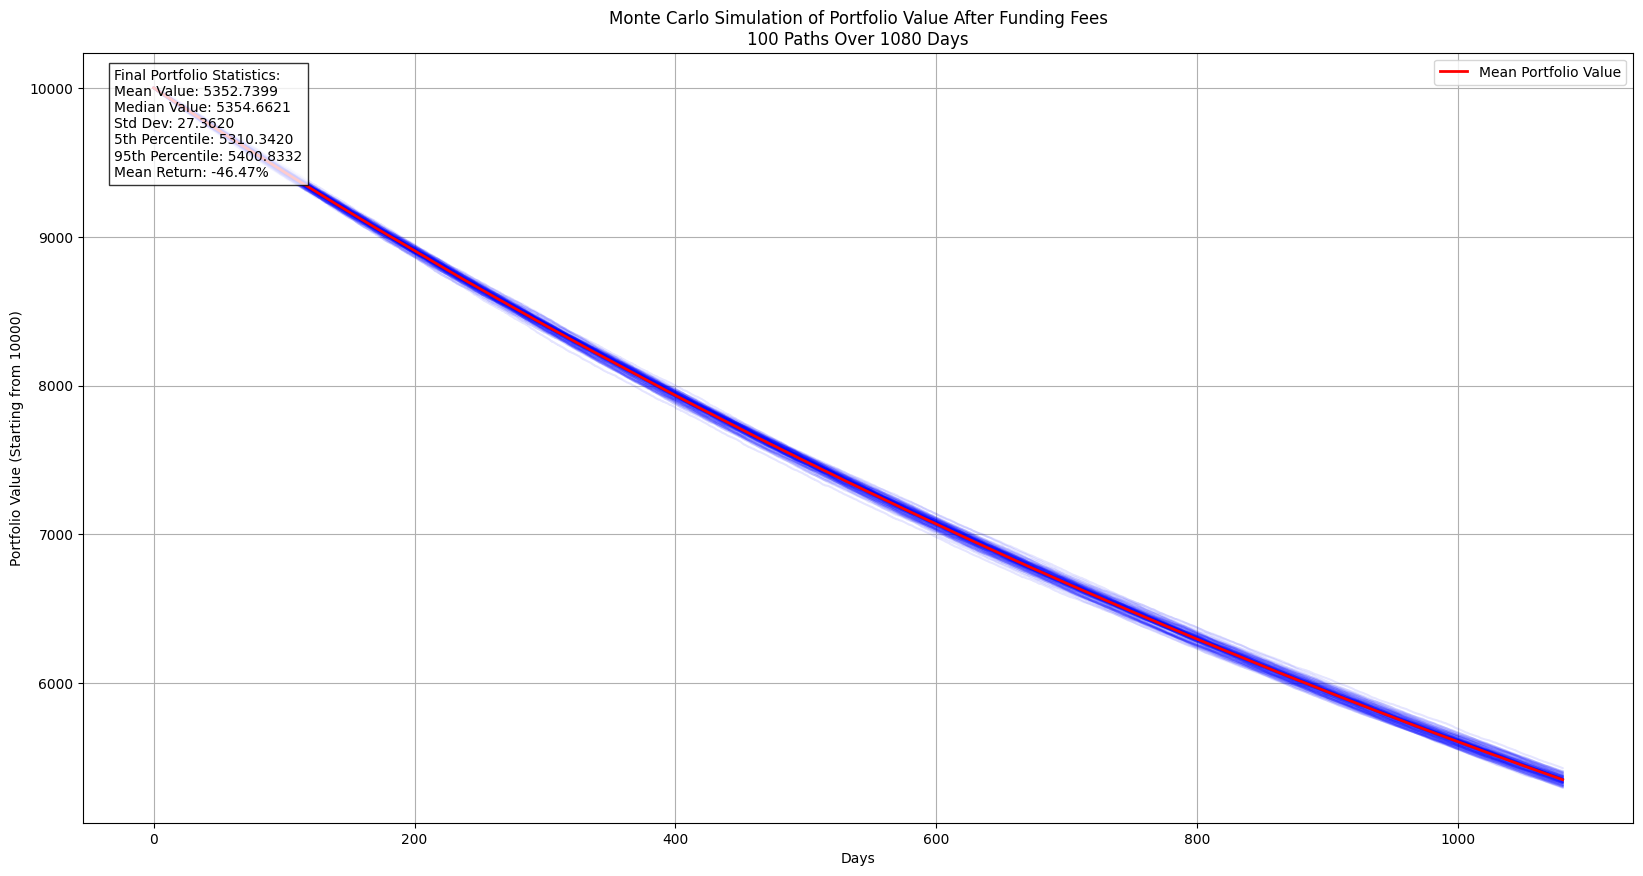

In [ ]:

def generate_samples(data, n_steps, dist_type='kde', random_state=None):
    """
    Generate replicable samples using specified distribution
    
    Parameters:
        data: Historical funding rate data
        n_steps: Number of steps to generate
        dist_type: Type of distribution to fit ('kde', 'gamma', 'pearson')
        random_state: Seed for random number generation
    
    Returns:
        Array of generated samples
    """
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    if dist_type == 'kde':
        # For KDE, we need to set the random state explicitly
        kde = scipy_stats.gaussian_kde(data)
        # Store the original random state
        original_state = np.random.get_state()
        # Set the random state for this specific sampling
        np.random.seed(random_state)
        samples = kde.resample(n_steps)[0]
        # Restore the original random state
        np.random.set_state(original_state)
        return samples
    
    # elif dist_type == 'gamma':
    #     # Fit gamma distribution parameters
    #     shape, loc, scale = stats.gamma.fit(data)
    #     # Generate samples with explicit random_state
    #     return stats.gamma.rvs(shape, loc=loc, scale=scale, 
    #                          size=n_steps, random_state=random_state)
    
    elif dist_type == 'pearson':
        # Fit Pearson Type III distribution parameters
        shape, loc, scale = scipy_stats.pearson3.fit(data)
        # Generate samples with explicit random_state
        return scipy_stats.pearson3.rvs(shape, loc=loc, scale=scale, 
                                size=n_steps, random_state=random_state)
    
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

def simulate_portfolio_adjusted_funding(funding_rates_df, hourly_funding_col, num_simulations=1000, 
                                     duration_hours=2160, dist_type='kde', intial_size = 10000, random_state = 42):
    """
    Run Monte Carlo simulation of funding fees with portfolio size adjustment
    
    Parameters:
        funding_rates_df: DataFrame with fundingRate column
        num_simulations: Number of paths to simulate
        duration_hours: Length of simulation (default 3 months)
        dist_type: Distribution type ('kde', 'gamma', 'pearson')
        initial_portfolio: Starting portfolio size (normalized to 1.0)
    
    Returns:
        portfolio_values: Array of portfolio values over time for each simulation
        funding_rates: Array of simulated funding rates
    """
    rates = funding_rates_df[hourly_funding_col].values
    
    # Initialize arrays
    funding_rates = np.zeros((num_simulations, duration_hours))
    portfolio_values = np.zeros((num_simulations, duration_hours + 1))
    
    # Set initial portfolio value for all simulations
    portfolio_values[:, 0] = intial_size
    
    # Generate paths using specified distribution
    for i in range(num_simulations):
        funding_rates[i] = generate_samples(data=rates, n_steps=duration_hours, dist_type=dist_type, random_state=random_state + i)
        
        # Calculate portfolio value evolution
        for t in range(duration_hours):
            # Current portfolio value affects the funding payment
            funding_payment = portfolio_values[i, t] * (funding_rates[i, t])
            # Update portfolio value after funding payment
            portfolio_values[i, t + 1] = portfolio_values[i, t] - funding_payment
    
    # Create visualization
    plt.figure(figsize=(20, 10))
    time_points = np.arange(duration_hours + 1)
    
    # Plot all individual paths with low opacity
    for path in portfolio_values:
        plt.plot(time_points / 24, path, color='blue', alpha=0.1)
    
    # Plot mean path with higher visibility
    mean_path = np.mean(portfolio_values, axis=0)
    plt.plot(time_points / 24, mean_path, color='red', linewidth=2, 
             label='Mean Portfolio Value')
    
    # Add percentile bands
    # percentiles = np.percentile(portfolio_values, [5, 25, 75, 95], axis=0)
    # plt.fill_between(time_points / 24, percentiles[0], percentiles[1],
    #                  color='gray', alpha=0.3, label='5th-25th Percentile')
    # plt.fill_between(time_points / 24, percentiles[2], percentiles[3],
    #                  color='gray', alpha=0.3, label='75th-95th Percentile')
    
    # Add summary statistics
    final_values = portfolio_values[:, -1]
    total_return = (final_values - intial_size) / intial_size * 100
    
    plt.text(0.02, 0.98, 
             f'Final Portfolio Statistics:\n' +
             f'Mean Value: {np.mean(final_values):.4f}\n' +
             f'Median Value: {np.median(final_values):.4f}\n' +
             f'Std Dev: {np.std(final_values):.4f}\n' +
             f'5th Percentile: {np.percentile(final_values, 5):.4f}\n' +
             f'95th Percentile: {np.percentile(final_values, 95):.4f}\n' +
             f'Mean Return: {np.mean(total_return):.2f}%',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.xlabel('Days')
    plt.ylabel(f'Portfolio Value (Starting from {intial_size})')
    plt.title(f'Monte Carlo Simulation of Portfolio Value After Funding Fees\n'
              f'{num_simulations} Paths Over {duration_hours/24:.0f} Days')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return portfolio_values, funding_rates
    
portfolio_values, funding_rates  = simulate_portfolio_adjusted_funding(hl_df,hourly_funding_col='fundingRate', num_simulations=100, duration_hours=24 * 30 * 12 * 3, dist_type='pearson')

# 4 What is the expected loss in Funding based for the different tokens?

Hyperliquid : Querying funding data for BTC from 2023-07-01 08:00:00 to 2025-02-01 16:17:37
Running Monte Carlo Simulation for : BTC


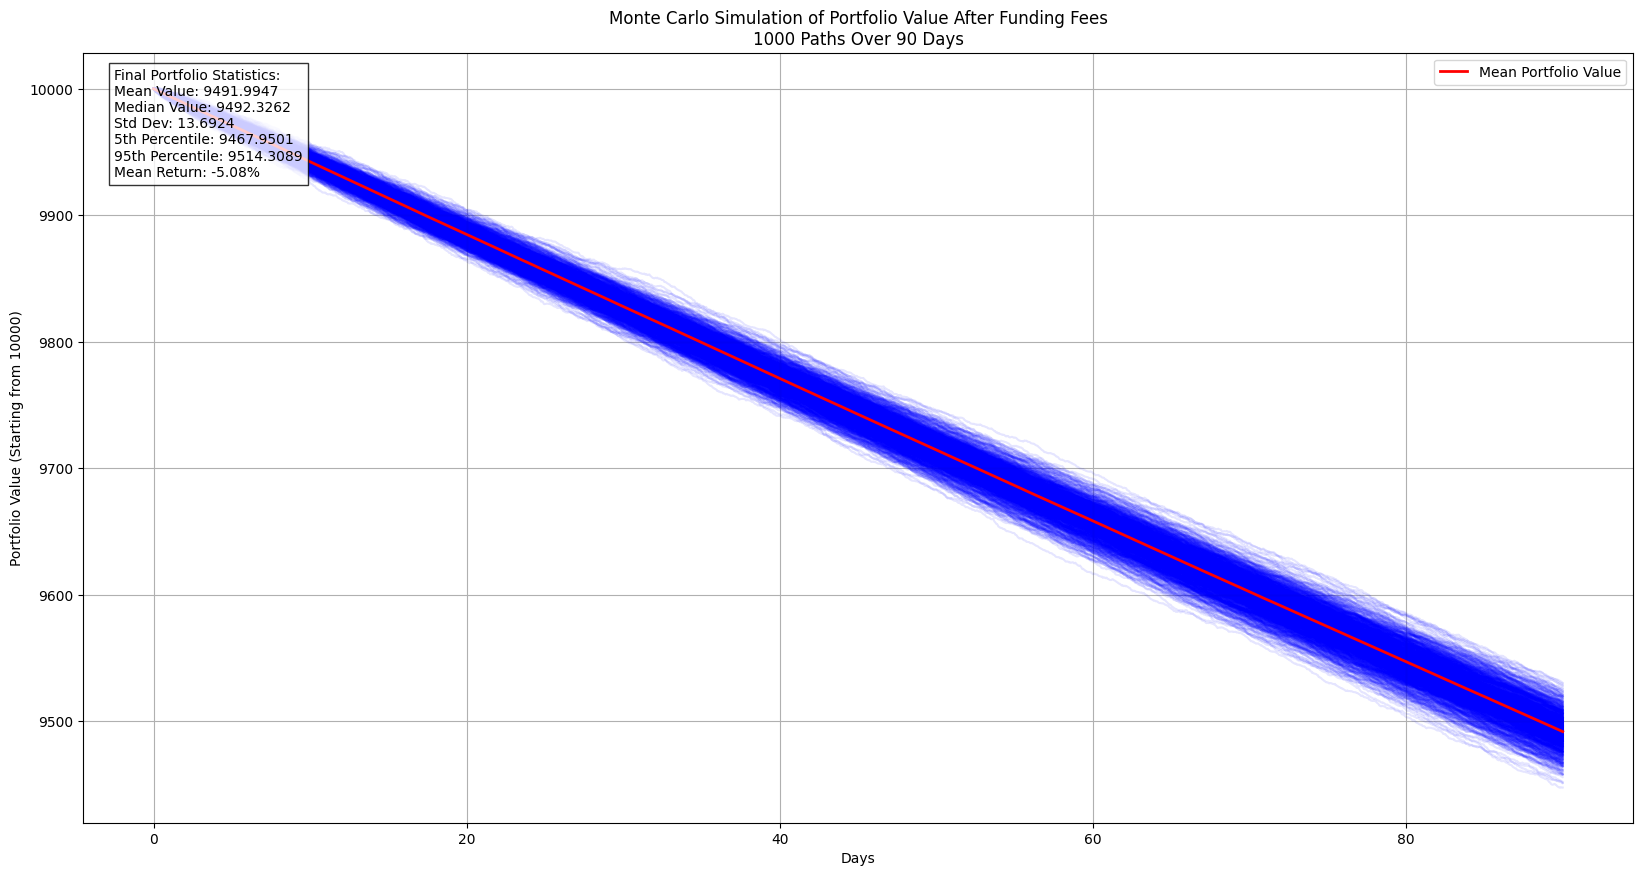

Hyperliquid : Querying funding data for ETH from 2023-07-01 08:00:00 to 2025-02-01 16:17:37
Running Monte Carlo Simulation for : ETH


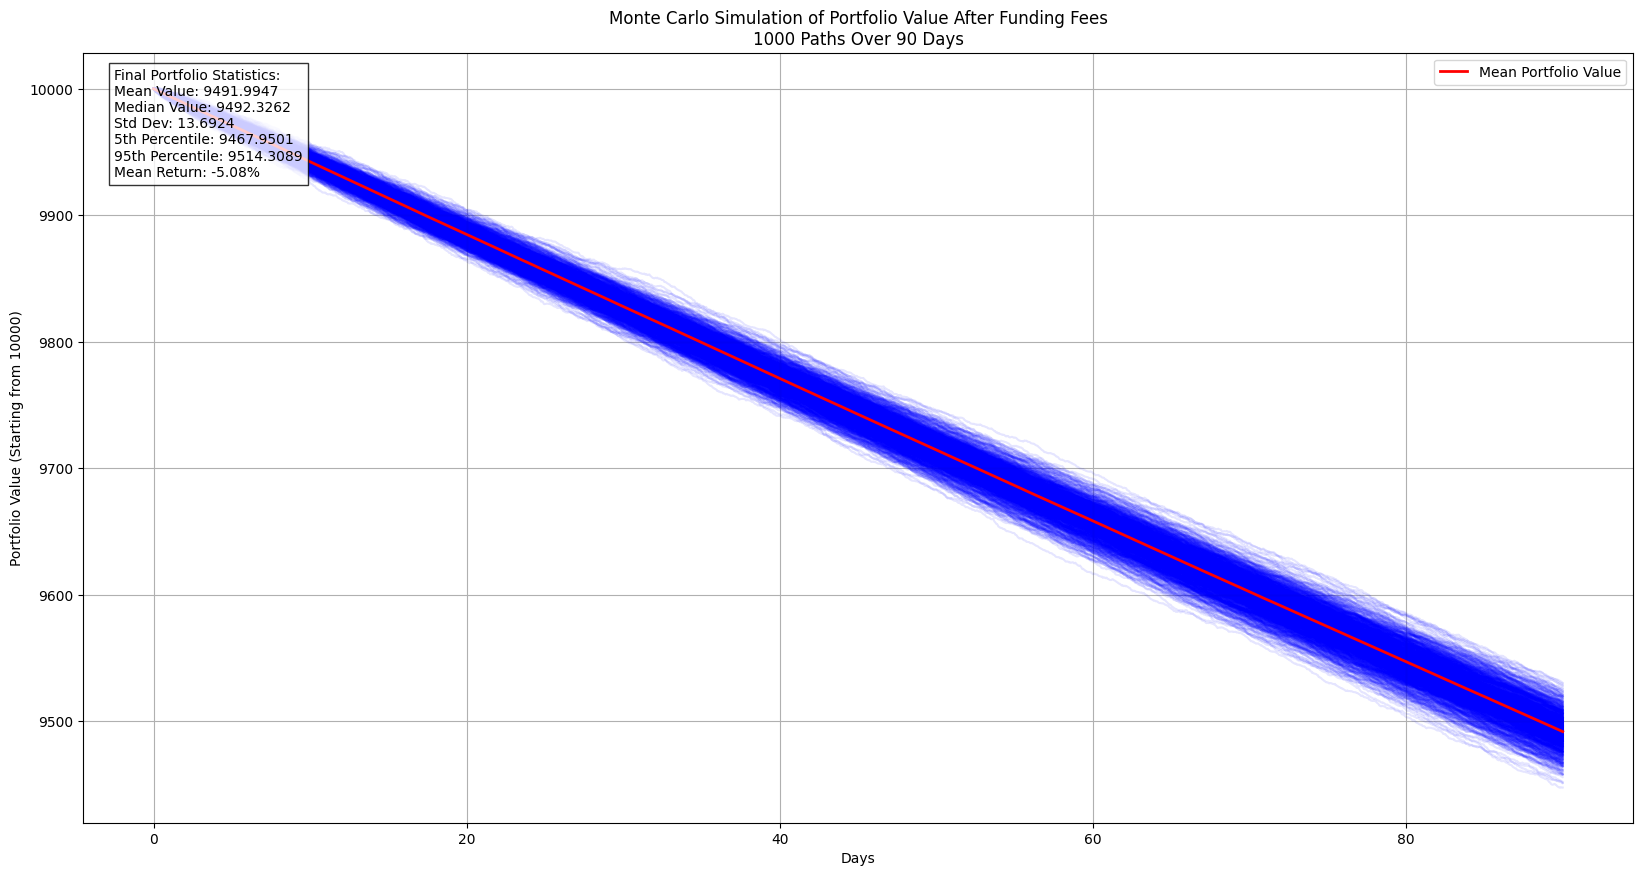

Hyperliquid : Querying funding data for SOL from 2023-07-01 08:00:00 to 2025-02-01 16:17:37
Running Monte Carlo Simulation for : SOL


KeyboardInterrupt: 

In [18]:
tokens = ["BTC", "ETH", "SOL", "XRP", ]
startTime = int(datetime(2023, 7, 1, 0, 0, 0, tzinfo=pytz.UTC).timestamp() * 1000)

num_simulations = 1000
duration_hours = 24 * 30 * 3
dist_type = 'pearson'
initial_size = 10000

for t in tokens:
    hl_token = get_hyperliquid_funding(instrument=t, startTime=startTime)
    hl_df_token = pd.DataFrame(hl_token)
    hl_df_token['fundingRate'] = hl_df_token['fundingRate'].astype(float)
    print(f"""Running Monte Carlo Simulation for : {t}""")
    portfolio_values, funding_rates  = simulate_portfolio_adjusted_funding(
        funding_rates_df = hl_df_token,
        hourly_funding_col='fundingRate', 
        num_simulations=num_simulations, 
        duration_hours=duration_hours, 
        dist_type=dist_type,
        intial_size=initial_size)
